<a href="https://colab.research.google.com/github/TUCchkul/NER_Project/blob/main/Name_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ner Token Classification 

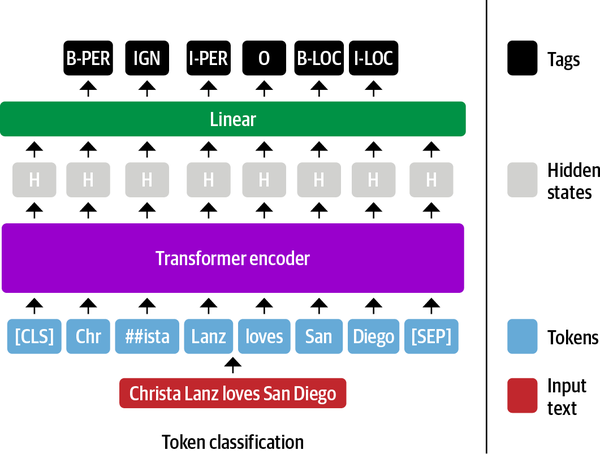

# Initial Project Setup 

In [ ]:
# Uncomment and run this cell if you're on Colab or Kaggle
"""
By pretraining on huge corpora across many languages, 
these multilingual transformers enable zero-shot cross-lingual transfer. 
This means that a model that is fine-tuned on one language can be applied to others without any further training!

"""
!git clone https://github.com/nlp-with-transformers/notebooks.git

import os
os.chdir("/content/notebooks")


from install import *
install_requirements()

Cloning into 'notebooks'...
remote: Enumerating objects: 416, done.
remote: Total 416 (delta 0), reused 0 (delta 0), pack-reused 416
Receiving objects: 100% (416/416), 24.47 MiB | 23.75 MiB/s, done.
Resolving deltas: 100% (190/190), done.
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


# Device Setup Pytorch

In [ ]:
from utils import *
setup_chapter()


import pandas as pd
import numpy as np 
import torch 

print(torch.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

Using transformers v4.11.3
Using datasets v1.16.1
1.11.0+cu113
cuda


# DownLoading Benchmark Dataset 

In [ ]:
# Data ingestion Phase

from datasets import get_dataset_config_names
from datasets import load_dataset
from datasets import load_from_disk

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]

Downloading:   0%|          | 0.00/9.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

XTREME has 183 configurations


In [ ]:
print("All PanX languages \n")
print(panx_subsets)

en = load_dataset("xtreme", name='PAN-X.en')

print("English Dataset \n")
print(en)

All PanX languages

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg', 'PAN-X.bn', 'PAN-X.de', 'PAN-X.el',
'PAN-X.en', 'PAN-X.es', 'PAN-X.et', 'PAN-X.eu', 'PAN-X.fa', 'PAN-X.fi',
'PAN-X.fr', 'PAN-X.he', 'PAN-X.hi', 'PAN-X.hu', 'PAN-X.id', 'PAN-X.it',
'PAN-X.ja', 'PAN-X.jv', 'PAN-X.ka', 'PAN-X.kk', 'PAN-X.ko', 'PAN-X.ml',
'PAN-X.mr', 'PAN-X.ms', 'PAN-X.my', 'PAN-X.nl', 'PAN-X.pt', 'PAN-X.ru',
'PAN-X.sw', 'PAN-X.ta', 'PAN-X.te', 'PAN-X.th', 'PAN-X.tl', 'PAN-X.tr',
'PAN-X.ur', 'PAN-X.vi', 'PAN-X.yo', 'PAN-X.zh']


Downloading:   0%|          | 0.00/234M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

English Dataset

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
})


# Data Exploration /  Configuration File 

### Train Data exploration

In [ ]:
for i in en["train"]:
  print(pd.DataFrame(i))
  break

      tokens  ner_tags langs
0       R.H.         3    en
1   Saunders         4    en
2          (         0    en
3        St.         3    en
4   Lawrence         4    en
5      River         4    en
6          )         0    en
7          (         0    en
8        968         0    en
9         MW         0    en
10         )         0    en


In [ ]:
pd.DataFrame(en["train"][100]).transpose()

,0,1,2,3,4
tokens,List,of,years,in,Brazil
ner_tags,3,4,4,4,4
langs,en,en,en,en,en


### Ner Tags

In [ ]:
 en["train"].features

{'langs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], names_file=None, id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [ ]:
 en["train"].features["ner_tags"]

Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], names_file=None, id=None), length=-1, id=None)

In [ ]:
en["train"].features["ner_tags"].feature.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [ ]:
en["train"].features["ner_tags"].feature

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], names_file=None, id=None)

### Tags Object

In [ ]:
tags = en["train"].features["ner_tags"].feature
print(tags)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG',
'B-LOC', 'I-LOC'], names_file=None, id=None)


In [ ]:
tags.int2str(0)

'O'

In [ ]:
tags.str2int('B-PER')

1

In [ ]:
# Data train , validation , test 
# train - > tokens, ner_tags, lang
# select ner_tags -> apply int2str as shown  

def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

new_en = en.map(create_tag_names)

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/20000 [00:00<?, ?ex/s]

In [ ]:
de_example = new_en["train"][100]
pd.DataFrame([de_example["tokens"],de_example["ner_tags"] ,de_example["ner_tags_str"]],
['Tokens',"ner_tags" ,'ner_tags_str'])


,0,1,2,3,4
Tokens,List,of,years,in,Brazil
ner_tags,3,4,4,4,4
ner_tags_str,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG


In [ ]:
new_en

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 20000
    })
})

# Xlmr - Tokenizer

In [ ]:
# XLM-R - > 250,000
# Instead of using a WordPiece tokenizer, XLM-R uses a tokenizer called SentencePiece.
# Vocab - after tokenization repace with index position
# white spaces as _ to preserve the space

In [ ]:
from transformers import AutoTokenizer
xlmr_model_name = "xlm-roberta-base"
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [ ]:
xlmr_tokenizer('Hello my name is')

{'input_ids': [0, 35378, 759, 9351, 83, 2], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
xlmr_tokens = xlmr_tokenizer('Hello my name is ketan and i am working at ineuron').tokens()
xlmr_tokens 

['<s>',
 '▁Hello',
 '▁my',
 '▁name',
 '▁is',
 '▁ke',
 'tan',
 '▁and',
 '▁i',
 '▁am',
 '▁working',
 '▁at',
 '▁in',
 'euro',
 'n',
 '</s>']

# Custom Model Building with Pytorch and hugging face
## Model Architecture file

![nlpt_0404](https://user-images.githubusercontent.com/40850370/176989445-bbf9d48d-3244-4176-b7e0-9440a4ff1b37.png)


In [ ]:
# we will use RoBERTa as the base model but augmented with settings specific to XLM-R. 
# The config_class ensures that the standard XLM-R settings are used when we initialize a new model.
# Note that we set add_​pool⁠ing_layer=False to ensure all hidden states are returned and not only the one associated with the [CLS] token.
# Finally, we initialize all the weights by calling the init_weights()

import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits,
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions)

# Auto Configuration 

In [ ]:
# The AutoConfig class contains the blueprint of a model’s architecture. 
# some additional information beyond the model name, 
# including the tags that we will use to label each entity and the mapping of each tag to an ID and vice versa.

In [ ]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [ ]:
index2tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC'}

In [ ]:
tag2index

{'B-LOC': 5,
 'B-ORG': 3,
 'B-PER': 1,
 'I-LOC': 6,
 'I-ORG': 4,
 'I-PER': 2,
 'O': 0}

In [ ]:
xlmr_model_name

'xlm-roberta-base'

In [ ]:
tags.num_classes

7

In [ ]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [ ]:
xlmr_model_name

'xlm-roberta-base'

In [ ]:
xlmr_config

XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

# Quick Prediction

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print(device)


xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

cuda


Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

In [ ]:
new_en["train"][100]

{'langs': ['en', 'en', 'en', 'en', 'en'],
 'ner_tags': [3, 4, 4, 4, 4],
 'ner_tags_str': ['B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG'],
 'tokens': ['List', 'of', 'years', 'in', 'Brazil']}

In [ ]:
" ".join(new_en["train"][100]["tokens"])

'List of years in Brazil'

In [ ]:
text ='List of years in Brazil'


input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")

In [ ]:
input_ids

tensor([[    0, 32036,   111,  5369,    23, 30089,     2]])

In [ ]:
outputs = xlmr_model(input_ids.to(device)).logits

predictions = torch.argmax(outputs, dim=-1)

print(f"Number of tokens in sequence: {len(xlmr_tokens)}")

print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 16
Shape of outputs: torch.Size([1, 7, 7])


In [ ]:
data = [i.item() for i in predictions[0]]
data

[1, 6, 6, 6, 4, 6, 1]

In [ ]:
index2tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC'}

In [ ]:
[index2tag[idx] for idx in data][1:-1]

['I-LOC', 'I-LOC', 'I-LOC', 'I-ORG', 'I-LOC']

In [ ]:
['B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG']

In [ ]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Tokens,<s>,▁Hello,▁my,▁name,▁is,▁ke,tan,▁and,▁i,▁am,▁working,▁at,▁in,euro,n,</s>
Tags,B-PER,I-LOC,I-LOC,I-LOC,I-ORG,I-LOC,B-PER,None,None,None,None,None,None,None,None,None


In [ ]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

  

# Tokenizing Texts for NER

In [ ]:
de_example = new_en["train"][8]

In [ ]:
# In this example we can see that the tokenizer has split, 
# Since we’re following the convention that only first word
# should be associated with the B-LOC label, we need a way to mask the 
# subword representations after the first subword. Fortunately, 
# tokenized_input is a class that contains a word_ids() function that can help us achieve this:

words, labels = de_example["tokens"], de_example["ner_tags"]
words, labels

(['*Inducted',
  'into',
  'the',
  'United',
  'States',
  'Hockey',
  'Hall',
  'of',
  'Fame',
  'in',
  '2015'],
 [0, 0, 0, 3, 4, 4, 4, 4, 4, 0, 0])

In [ ]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokenized_input

{'input_ids': [0, 661, 4153, 77193, 297, 3934, 70, 14098, 46684, 193171, 19449, 111, 52917, 13, 23, 918, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['<s>',
 '▁*',
 'In',
 'duct',
 'ed',
 '▁into',
 '▁the',
 '▁United',
 '▁States',
 '▁Hockey',
 '▁Hall',
 '▁of',
 '▁Fam',
 'e',
 '▁in',
 '▁2015',
 '</s>']

In [ ]:
word_ids = tokenized_input.word_ids()
word_ids

[None, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 9, 10, None]

##Concept
 
Why did we choose –100 as the ID to mask subword representations? The reason is that in PyTorch the cross-entropy loss class torch.nn.CrossEntropyLoss has an attribute called ignore_index whose value is –100. This index is ignored during training, so we can use it to ignore the tokens associated with consecutive subwords.

[0, 0, 0, 3, 4, 4, 4, 4, 4, 0, 0]

In [ ]:
[index2tag[idx] for idx in [0, 0, 0, 3, 4, 4, 4, 4, 4, 0, 0]][1:-1]

['O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O']

In [ ]:
new_en["train"][8]['tokens']

['*Inducted',
 'into',
 'the',
 'United',
 'States',
 'Hockey',
 'Hall',
 'of',
 'Fame',
 'in',
 '2015']

In [ ]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Tokens,<s>,▁*,In,duct,ed,▁into,▁the,▁United,▁States,▁Hockey,▁Hall,▁of,▁Fam,e,▁in,▁2015,</s>
Word IDs,None,0,0,0,0,1,2,3,4,5,6,7,8,8,9,10,None
Label IDs,-100,0,-100,-100,-100,0,0,3,4,4,4,4,4,-100,0,0,-100
Labels,IGN,O,IGN,IGN,IGN,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,O,O,IGN


In [ ]:
# O	Outside of a named entity
# B-MIS	Beginning of a miscellaneous entity right after another miscellaneous entity
# I-MIS	Miscellaneous entity
# B-PER	Beginning of a person’s name right after another person’s name
# I-PER	Person’s name
# B-ORG	Beginning of an organization right after another organization
# I-ORG	organization
# B-LOC	Beginning of a location right after another location
# I-LOC	Location

# IGN - Ignore

In [ ]:
new_en["train"][8]["ner_tags"]

[0, 0, 0, 3, 4, 4, 4, 4, 4, 0, 0]

In [ ]:
# apply this to whole dataset
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True,
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [ ]:
panx_en_encoded = encode_panx_dataset(new_en) 

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

In [ ]:
panx_en_encoded

DatasetDict({
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'ner_tags_str'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'ner_tags_str'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'ner_tags_str'],
        num_rows: 20000
    })
})

# Prediction Matrics

#### Evaluating a NER model is similar to evaluating a text classification model, and it is common to report results for precision, recall, and F1-score. The only subtlety is that all words of an entity need to be predicted correctly in order for a prediction to be counted as correct.

In [ ]:
from seqeval.metrics import classification_report

In [ ]:
y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [ ]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

In [ ]:
from transformers import TrainingArguments

num_epochs = 5

batch_size = 24

logging_steps = len(panx_en_encoded["train"].select(range(100))) // batch_size

model_name = f"{xlmr_model_name}-finetuned-panx-en"

training_args = TrainingArguments(
    output_dir=model_name, 
    log_level="error", 
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, 
    evaluation_strategy="epoch",
    save_steps=1e6, 
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps
    )

In [ ]:
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_steps=None,
evaluation_strategy=IntervalStrategy.EPOCH,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
hub_model_id=None,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
label_names=None,
label_smoothing_factor=0.0,
learning_rate=5e-05,
length_column_name=length,
load_best_model_at_end=False,
local_rank=-1,
log_level=40,
log_level_replica=-1,
log_on_each_node=True,
logging_dir=xlm-roberta-base-finetuned-panx-en/runs/Jul02_07-04-30_bbf8807e789b,
logging_first_step=False,
logging_nan_

In [ ]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [ ]:
# The final step is to define a data collator so we can pad each input sequence 
# to the largest sequence length in a batch. nlpt_pin01 Transformers provides a
# dedicated data collator for token classification that will pad the labels along with the inputs:

from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [ ]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [ ]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_en_encoded["train"].select(range(100)),
                  eval_dataset=panx_en_encoded["validation"].select(range(10)),
                  tokenizer=xlmr_tokenizer)

In [ ]:
trainer.train() 

Epoch,Training Loss,Validation Loss,F1
1,1.709000,1.575682,0.000000
2,1.487500,1.421227,0.000000
3,1.432300,1.311007,0.086957
4,1.134300,1.235702,0.181818
5,0.984700,1.210620,0.324324


TrainOutput(global_step=25, training_loss=1.2933076763153075, metrics={'train_runtime': 7.2932, 'train_samples_per_second': 68.557, 'train_steps_per_second': 3.428, 'total_flos': 12677548522320.0, 'train_loss': 1.2933076763153075, 'epoch': 5.0})

# Model Prediction 

In [ ]:
input_ids = xlmr_tokenizer(new_en["validation"][:10]["tokens"],truncation=True,
                                      is_split_into_words=True)


In [ ]:
data = torch.tensor(panx_en_encoded["validation"][0:1]["input_ids"])

In [ ]:
outputs = xlmr_model(data.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 16
Shape of outputs: torch.Size([1, 18, 7])


In [ ]:
outputs

tensor([[[ 0.0175,  0.4728,  0.6228, -0.7068, -0.3506,  0.1742,  0.4241],
         [-0.0487,  0.4016,  0.6054, -0.6290, -0.2859,  0.1243,  0.4985],
         [ 0.0240,  0.3372,  0.5057, -0.6562, -0.2885,  0.1545,  0.4830],
         [ 0.1610,  0.3176,  0.5455, -0.6136, -0.2124,  0.1846,  0.3900],
         [ 0.0789,  0.3092,  0.4953, -0.6633, -0.2423,  0.1507,  0.3426],
         [ 0.1010,  0.4687,  0.5600, -0.6082, -0.2220,  0.0135,  0.3166],
         [ 0.0628,  0.4646,  0.6388, -0.6670, -0.2028,  0.1425,  0.3829],
         [-0.0332,  0.3643,  0.6014, -0.6015, -0.2857,  0.1639,  0.5092],
         [ 0.0224,  0.3322,  0.4945, -0.6582, -0.2716,  0.1421,  0.4938],
         [ 0.1671,  0.3189,  0.5627, -0.6240, -0.1950,  0.1952,  0.3841],
         [ 0.0831,  0.3067,  0.4974, -0.6583, -0.2418,  0.1901,  0.3429],
         [ 0.1165,  0.5027,  0.5305, -0.5413, -0.2272,  0.0282,  0.2373],
         [ 0.1239,  0.3280,  0.6127, -0.6418, -0.1585,  0.1243,  0.3073],
         [ 0.1862,  0.4257,  0.6194, -

In [ ]:
data

tensor([[    0,   602,    31,  6077, 69944, 40024,    15,   602,    31,  6077,
         69944,     6,     4, 25134,   930, 38898,  1388,     2]])

In [ ]:
tokens = xlmr_tokenizer.convert_ids_to_tokens(data[0])
" ".join(tokens)

'<s> ▁Si o ux ▁Falls ▁Arena ▁( ▁Si o ux ▁Falls ▁ , ▁South ▁Da kota ▁) </s>'

In [ ]:
pred_tags = [index2tag[i.item()] for i in predictions[0]][1:-1]
pred_tags

['I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'B-PER',
 'I-PER',
 'I-PER']

In [ ]:

" ".join([index2tag[i.item()] for i in predictions[0]])

'I-PER I-PER I-PER I-PER I-PER I-PER I-PER I-PER I-PER I-PER I-PER I-PER I-PER I-PER B-PER I-PER I-PER I-PER'

In [ ]:
output = xlmr_tokenizer.convert_tokens_to_string(tokens)

In [ ]:
output[3:-4].split()

['Sioux', 'Falls', 'Arena', '(', 'Sioux', 'Falls', ',', 'South', 'Dakota', ')']

In [ ]:
pd.Series([index2tag[i] for i in [i for i in panx_en_encoded["validation"][0]['labels'] if i!= -100 ]])

0    B-ORG
1    I-ORG
2    I-ORG
3        O
4    B-LOC
5    I-LOC
6    I-LOC
7    I-LOC
8    I-LOC
9        O
dtype: object

In [ ]:
pd.Series(output[3:-4].split())

0     Sioux
1     Falls
2     Arena
3         (
4     Sioux
5     Falls
6         ,
7     South
8    Dakota
9         )
dtype: object

In [ ]:
panx_en_encoded["validation"][0]['labels']

[-100, 3, -100, -100, 4, 4, 0, 5, -100, -100, 6, 6, -100, 6, 6, -100, 0, -100]

In [ ]:
xlmr_tokenizer.convert_ids_to_tokens(panx_en_encoded["validation"][0]["input_ids"])

['<s>',
 '▁Si',
 'o',
 'ux',
 '▁Falls',
 '▁Arena',
 '▁(',
 '▁Si',
 'o',
 'ux',
 '▁Falls',
 '▁',
 ',',
 '▁South',
 '▁Da',
 'kota',
 '▁)',
 '</s>']

In [ ]:
panx_en_encoded["validation"][0]['ner_tags_str']

['B-ORG',
 'I-ORG',
 'I-ORG',
 'O',
 'B-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'O']